In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
from os.path import expanduser
from pandas import read_csv
from pandas import DataFrame
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from numpy import array, add, divide
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

## Import data

In [3]:
home = expanduser('~')
my_path = f'{home}/Downloads/project_mining_2022/dataset/amazon.csv'

In [4]:
reviews = read_csv(my_path)
reviews.columns = ['text_review', 'rating']
reviews.head()

,text_review,rating
0,The description and photo on this product need...,3
1,This was a great book!!!! It is well thought t...,5
2,"I am a first year teacher, teaching 5th grade....",5
3,I got the book at my bookfair at school lookin...,5
4,Hi! I'm Martine Redman and I created this puzz...,5


## Preproccessing

### Noise Removal, Lowercasing and Normalization

In [5]:
reviews['text_review'] = reviews['text_review'].map(simple_preprocess)
reviews.head()

,text_review,rating
0,"[the, description, and, photo, on, this, produ...",3
1,"[this, was, great, book, it, is, well, thought...",5
2,"[am, first, year, teacher, teaching, th, grade...",5
3,"[got, the, book, at, my, bookfair, at, school,...",5
4,"[hi, martine, redman, and, created, this, puzz...",5


### Stop words removal 

In [6]:
def remove_stopwords(sentence_as_list):
    stop_words = set(stopwords.words('english'))
    return [word for word in sentence_as_list if word not in stop_words]
            
            
reviews['text_review'] = reviews['text_review'].map(remove_stopwords)
reviews.head()

,text_review,rating
0,"[description, photo, product, needs, changed, ...",3
1,"[great, book, well, thought, easily, imagine, ...",5
2,"[first, year, teacher, teaching, th, grade, sp...",5
3,"[got, book, bookfair, school, looking, somethi...",5
4,"[hi, martine, redman, created, puzzle, briarpa...",5


In [7]:
# remove blanks
reviews = reviews[reviews['text_review'].map(len) > 0]

In [8]:
text_reviews = reviews['text_review'].values
Y = reviews['rating'].values

## Word Embeddings model creation - Word2Vec

In [9]:
model = Word2Vec(
    window=5,
    min_count=1,
    workers=4
)
model.build_vocab(text_reviews, progress_per=1000)

In [10]:
model.train(text_reviews, total_examples=model.corpus_count, epochs=model.epochs)

(8892214, 9327490)

In [11]:
model.save('./amazon_reviews_trained_word2vec')

In [12]:
model.wv.most_similar('computer')

[('phone', 0.831372857093811),
 ('tv', 0.7898821830749512),
 ('video', 0.787908136844635),
 ('controller', 0.7669413089752197),
 ('dvd', 0.7648599147796631),
 ('correctly', 0.7647402882575989),
 ('camera', 0.7619369029998779),
 ('track', 0.7561458349227905),
 ('programming', 0.7558457255363464),
 ('click', 0.7552931308746338)]

In [13]:
model.wv.similarity(w1='great', w2='awesome')

0.69963557

### Pair words to embeddings

In [14]:
word_vec = dict({})
for key in model.wv.index_to_key:
    word_vec[key] = model.wv[key]

### Create document vectors

In [15]:
docVec = []
# for every review
for i in range(len(text_reviews)):
    sentVect = array(100)
    # for each word in review
    for j in range(len(text_reviews[i])):
        word = text_reviews[i][j]
        if word in word_vec.keys():
            # vector addition of the words in the text
            sentVect = add(sentVect, word_vec[word])
            
    # normalize vector
    sentVect = divide(sentVect, len(text_reviews[i]))
    docVec.append(sentVect)

In [16]:
doc_vectors = DataFrame(docVec)
doc_vectors['rating'] = Y
doc_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,rating
0,8.930763,9.755676,8.825501,9.091612,9.261006,8.805261,9.045771,10.330650,9.018737,9.168095,...,8.955268,8.865531,9.065722,9.297515,9.257125,9.275002,8.493711,9.015067,9.062284,3
1,4.154589,4.595779,3.626750,4.336873,3.765345,3.671777,4.200261,4.631725,3.600538,3.436242,...,4.309210,3.297069,3.806753,4.316444,3.643270,4.313126,3.549628,3.973354,3.774004,5
2,1.995172,2.586228,1.876438,2.239799,1.896880,1.642775,2.103675,2.506651,1.557393,1.640833,...,2.352439,1.560052,1.790077,2.080339,2.126987,2.119798,1.701594,1.450907,1.694897,5
3,2.514477,2.827030,2.020205,2.761392,2.073751,2.153449,2.468775,2.795637,1.780922,2.106992,...,2.500124,2.191502,2.153658,2.285943,2.274668,2.560371,1.862178,1.985591,1.961489,5
4,1.540096,2.008163,1.448637,1.647356,1.465960,1.452590,1.705276,2.080120,1.483858,1.330621,...,1.717883,1.124554,1.381857,1.576245,1.634688,1.838305,1.416195,1.254740,1.556007,5


### Class Sample distribution

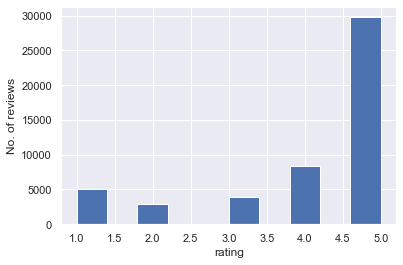

In [17]:
plt.hist(doc_vectors['rating'])
plt.xlabel('rating')
plt.ylabel('No. of reviews')
plt.show()

## Data Normalization

In [18]:
scaler = MinMaxScaler()
scaled_doc_vectors = DataFrame(scaler.fit_transform(doc_vectors.drop(['rating'], axis=1)))
scaled_doc_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.089324,0.091805,0.088423,0.089166,0.093473,0.090222,0.085279,0.095243,0.096591,0.092974,...,0.085231,0.086418,0.093748,0.088288,0.089455,0.091422,0.093795,0.088076,0.087655,0.091633
1,0.042734,0.041876,0.036962,0.042723,0.039747,0.040026,0.038552,0.039809,0.044057,0.036027,...,0.041643,0.041065,0.039484,0.036788,0.040648,0.036172,0.045630,0.039595,0.038757,0.040120
2,0.021670,0.022431,0.019637,0.022239,0.021481,0.020185,0.018335,0.019138,0.024246,0.018190,...,0.024086,0.021963,0.022557,0.017040,0.018737,0.021249,0.024339,0.021473,0.014292,0.019867
3,0.026735,0.024761,0.021060,0.027334,0.023210,0.025179,0.021855,0.021949,0.026414,0.022821,...,0.026033,0.023405,0.028710,0.020600,0.020752,0.022702,0.028615,0.023048,0.019478,0.022464
4,0.017231,0.016838,0.015402,0.016452,0.017269,0.018326,0.014493,0.014989,0.023533,0.015108,...,0.015648,0.015769,0.018313,0.013042,0.013798,0.016404,0.021606,0.018675,0.012389,0.018514


### Balance class sample weight

In [19]:
# data are bias for '5' rating, so we generate new samples
# by randomly sampling with replacement of the currently available samples 
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(doc_vectors.drop(['rating'], axis=1), doc_vectors['rating'])
y_ros.value_counts()

3    29772
5    29772
4    29772
1    29772
2    29772
Name: rating, dtype: int64

### Split to train - test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x_ros, y_ros, test_size=0.2)

### Apply RandomForest Classifier

In [21]:
randomForest = RandomForestClassifier(n_estimators=20, random_state=42)
randomForest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [22]:
randomForest.score(X_test, y_test)

0.9545546150745667

In [23]:
y_pred = randomForest.predict(X_test)

### Confusion Matrix

In [24]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[5884,    1,    1,   10,   21],
       [   0, 5923,   16,    0,    0],
       [   2,    0, 5934,    2,    9],
       [  19,   12,   22, 5763,  246],
       [ 236,   52,   92,  612, 4915]], dtype=int64)

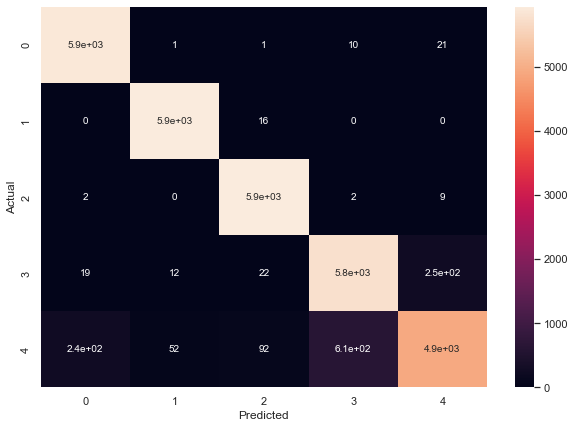

In [25]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###  f1 score, precision and recall 

In [26]:
print('Precision: %.3f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average='weighted'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='weighted'))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Precision: 0.955
Recall: 0.955
F1 Score: 0.954
Accuracy: 0.955
